In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

import ESC 


# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4710209180779842808
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10290429319432610964
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10874328966566073389
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12699046059946527967
physical_device_desc: "device: XLA_GPU device"
]


## Loading Functions

In [2]:
# Load raw data
def Load_RAW(path):
    '''
        Input:
            path: folder of the dataset
        
        Output:
            raw_data:  list that contains the raw data
            cvs:       list that contains the cross-fold number
            labels:    list that contains the category information
    '''
    
    # Container for the dataset
    raw_data = []
    cvs = []
    labels = []
    # Load every file inside the folder
    for file_name in tqdm(os.listdir(path)):

        try:
            # Get audio data and sampling rate
            audio, sampling_rate = librosa.load(os.path.join(path, file_name), res_type='kaiser_fast')
            # Split the file name
            name_splitted = re.split('[-.]', file_name)
            
            # Append a row of 3 elements
            raw_data.append(audio)
            cvs.append(name_splitted[0])
            labels.append(name_splitted[3])
        except Exception as e:
            pass
    
    # Convert to numpy array
    raw_audio = np.asarray(raw_data)
    cvs = np.asarray(cvs, dtype=int)
    labels = np.asarray(labels, dtype=int)
    
    # onehot encode the labels in 50 classes
    onehot_labels = to_categorical(labels, num_classes=50)
    
    return raw_audio, cvs, onehot_labels



def Split_Folds(raw_audio, cvs, labels, verbose=False):
    '''
        Input:
            raw_audio: list that contains the raw data
            cvs:       list that contains the cross-fold number
            labels:    list that contains the category information
            verbose:   flag used to print produced folds information
        
        Output:
            f{1,2,3,4,5}:      folds that contains the raw data and labels
    '''
    
    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []
    
    # Loop over each file audio
    for num, audio in enumerate(tqdm(raw_audio)):
        
        if cvs[num] == 1:
            f1.append((audio, labels[num]))
        elif cvs[num] == 2:
            f2.append([audio, labels[num]])
        elif cvs[num] == 3:
            f3.append([audio, labels[num]])
        elif cvs[num] == 4:
            f4.append([audio, labels[num]])
        elif cvs[num] == 5:
            f5.append([audio, labels[num]])
    
    # Convert to numpy array
    f1 = np.asarray(f1, dtype=object)
    f2 = np.asarray(f2, dtype=object)
    f3 = np.asarray(f3, dtype=object)
    f4 = np.asarray(f4, dtype=object)
    f5 = np.asarray(f5, dtype=object)
    
    if verbose:
        print("Folds size: %2d - %2d - %2d - %2d - %2d" % (len(f1), len(f2), len(f3), len(f4), len(f5)))

        print("Folds sample shape: ", len(f1[0]))

        print("Folds sample data shape: ", f1[0][0].shape)
        
        print("Folds sample label type: ", f1[0][1].shape)
    
    return f1, f2, f3, f4, f5


def Split_Data_Label(dataset):
    
    
    data = []
    label = []
    
    for i in range (len(dataset)):
        data.append(dataset[i][0])
        label.append(dataset[i][1])

    
    data = np.asarray(data)
    label = np.asarray(label)
    
    return data, label


# Load saved data
def Load_Augmented(name='', path='Augmented_Data/'):
    '''
        Input:
            name:      name of the file
            path:      path of the file
        
        Output:
            dataset:   loaded dataset with data and labels
    '''
    hf = h5py.File(path + name + '.h5', 'r')
    data =  np.array(hf.get('data'))
    labels = np.array(hf.get('label'))
    hf.close()
    
    data = np.asarray(data, dtype=np.float32)
    label = np.asarray(labels, dtype=np.int)
    return data, labels


def Preprocessing(raw_audio, labels, bands=60, frames=41):
    '''
        Input:
            raw_audio:     list that contains the raw/augmented data
            labels:        list that contains the category information
            bands:         number of mel band to use
            frames:        number of frames to use
        
        Output:
            features:      numpy array that contains processed audio data with log-melspec and delta
            new_labels:    new labels for each augmented segment
    '''    
    
    new_labels = []
    augmented_spec = []
    
    # Normalize the raw data
    norm_factor = np.percentile(raw_audio, 99) - np.percentile(raw_audio, 5)
    raw_audio = raw_audio / norm_factor
    
    # Loop over each file audio
    for num, audio in enumerate(tqdm(raw_audio)):
    
        # Convert audio to melspectogram
        '''
            With default n_fft=2048 we have the filter size of 2048/2+1=1025 [Nyquist Frequency]
        '''
        melspec = librosa.feature.melspectrogram(audio, n_mels=bands, hop_length=512)
        
        # Convert melspec to log melspec
        logspec = librosa.core.amplitude_to_db(melspec)
        
        counter = 0
        # Spectrogram splitting with 50% overlap and adapt cv-fold and labels info
        for idx in range(0, len(logspec[0]) - frames, int(frames/2)):
            augmented_spec.append(logspec[:, idx:idx+frames])
            new_labels.append(labels[num])
            counter = counter +1
            
    # Reshape the outputs
    log_specgrams = np.asarray(augmented_spec).reshape(len(augmented_spec), bands, frames, 1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis=3)
    new_labels = np.asarray(new_labels)
    
    # Fill the delta features
    for i in range(len(log_specgrams)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    features = features.astype(np.float32)
    labels = labels.astype(np.int)
    return features, new_labels

# Preprocessing
def Filtered_Preprocessing(raw_audio, labels, threshold=0.0001, bands=60, frames=41):
    '''
        Input:
            raw_audio:     list that contains the raw/augmented data
            labels:        list that contains the category information
            bands:         number of mel band to use
            frames:        number of frames to use
        
        Output:
            features:      numpy array that contains processed audio data with log-melspec and delta
            new_labels:    new labels for each augmented segment
    '''    

    
    segments = []
    segment_labels = []
    
    augmented_spec = []
    new_labels = []
    
    # Normalize the raw data
    norm_factor = np.percentile(raw_audio, 99) - np.percentile(raw_audio, 5)
    raw_audio = raw_audio / norm_factor
    
    # Loop over each file audio and divide into segments
    for num, audio in enumerate(tqdm(raw_audio)):
    
        # Convert audio to melspectogram
        '''
            With default n_fft=2048 we have the filter size of 2048/2+1=1025 [Nyquist Frequency]
        '''
        melspec = librosa.feature.melspectrogram(audio, n_mels=bands, hop_length=512)

        # Spectrogram splitting with 50% overlap and adapt cv-fold and labels info
        for idx in range(0, len(melspec[0]) - frames, int(frames/2)):
            segments.append(melspec[:, idx:idx+frames])
            segment_labels.append(labels[num])
        
    # Check and ignore silent segments
    for i, segment in enumerate(tqdm(segments)):
        
        # Append only non silent segments and convert into db
        if(np.mean(segment) >= threshold):
            augmented_spec.append(segment)
            new_labels.append(segment_labels[i])
    
    augmented_spec = np.asarray(augmented_spec)
    logspec = librosa.core.amplitude_to_db(augmented_spec)
    
    # Reshape the outputs
    log_specgrams = np.asarray(logspec).reshape(len(augmented_spec), bands, frames, 1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    new_labels = np.asarray(new_labels, dtype=int)
    
    # Fill the delta features
    for i in range(len(log_specgrams)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    features = features.astype(np.float32)
    labels = labels.astype(np.int)
    
    return features, new_labels



def CreateTrainingSet(f1, f2, f3, lf1, lf2, lf3, batch_size=32):
    
    # Create training set
    merged_training_data = np.concatenate((f1, f2, f3))
    merged_training_label = np.concatenate((lf1, lf2, lf3))
    
    merged_training_data = merged_training_data.astype(np.float64)
    merged_training_label = merged_training_label.astype(np.int)

    # Create and cache training
    training_dataset = tf.data.Dataset.from_tensor_slices((merged_training_data, merged_training_label))
    training_dataset = training_dataset.batch(batch_size=batch_size)
    training_dataset = training_dataset.cache("training_cache")
    training_dataset = training_dataset.prefetch(buffer_size=1)
    
    return training_dataset


def CreateTrainingSet_Single(f1, lf1, batch_size=32):
    
    f1 = f1.astype(dtype=np.float64)
    lf1 = lf1.astype(dtype=np.int)
    
    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((f1, lf1))
    validation_dataset = validation_dataset.cache("training_cache_single")
    validation_dataset = validation_dataset.batch(batch_size=batch_size)
    validation_dataset = validation_dataset.prefetch(buffer_size=1)
    
    return validation_dataset


def CreateValidationSet(f1, lf1, batch_size=32):
    
    f1 = f1.astype(dtype=np.float64)
    lf1 = lf1.astype(dtype=np.int)
    
    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((f1, lf1))
    validation_dataset = validation_dataset.cache("validation_cache")
    validation_dataset = validation_dataset.batch(batch_size=batch_size)
    validation_dataset = validation_dataset.prefetch(buffer_size=1)
    
    return validation_dataset

## Model Functions

In [3]:
def PiczakNet(input_shape):
    
    X_input = tf.keras.Input(input_shape)
    
    # First convolution block
    model = tf.keras.layers.Conv2D(80, kernel_size=(57, 6), strides=1, padding='same', name='conv0')(X_input)
    model = tf.keras.layers.Activation('relu')(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(4, 3), strides=(1, 3), padding='same')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second convolution block
    model = tf.keras.layers.Conv2D(80, kernel_size=(1, 3), strides=1, padding='same', name='conv1')(model)
    model = tf.keras.layers.Activation('relu')(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 3), padding='same')(model)
    
    # Flatten
    model = tf.keras.layers.Flatten()(model)
    
    # First fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc0')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc1')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Output layer
    model = tf.keras.layers.Dense(50, activation='softmax', name='out')(model)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = model, name='PiczakNet')
    
    return model

## Define the Network

Model: "PiczakNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 41, 2)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 60, 41, 80)        54800     
_________________________________________________________________
activation (Activation)      (None, 60, 41, 80)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 14, 80)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 14, 80)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 14, 80)        19280     
_________________________________________________________________
activation_1 (Activation)    (None, 60, 14, 80)        0 

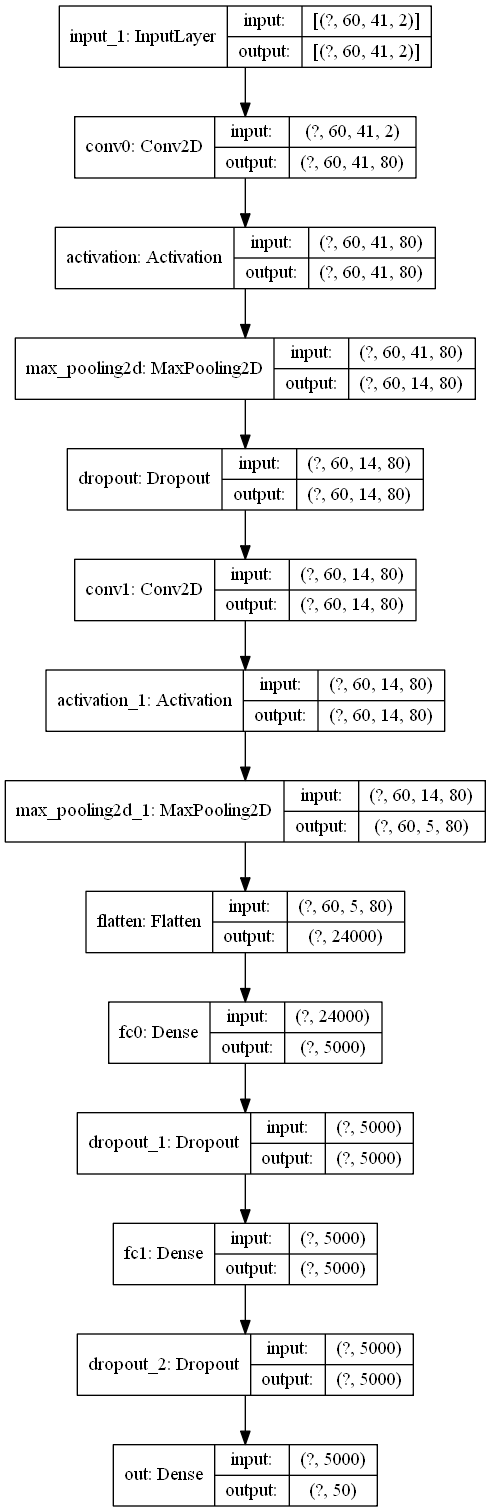

In [4]:
PiczakNet = PiczakNet([60, 41, 2])

print(PiczakNet.summary())

plot_model(PiczakNet, show_shapes=True, show_layer_names=True)

## Load Data

In [5]:
# Load raw data
'''
PATH = 'audio'
raw_files, cvs, labels = Load_RAW(PATH)

# Split the different folds
f1, f2, f3, f4, f5 = Split_Folds(raw_files, cvs, labels, verbose=True)
'''


"\nPATH = 'audio'\nraw_files, cvs, labels = Load_RAW(PATH)\n\n# Split the different folds\nf1, f2, f3, f4, f5 = Split_Folds(raw_files, cvs, labels, verbose=True)\n"

In [6]:
# Load
'''
af1, alf1 = Split_Data_Label(f1)
af2, alf2 = Split_Data_Label(f2)
af3, alf3 = Split_Data_Label(f3)
af4, alf4 = Split_Data_Label(f4)
af5, alf5 = Split_Data_Label(f5)
'''
af1, alf1 = Load_Augmented(name='af1', path='Augmented_2/')
af2, alf2 = Load_Augmented(name='af2', path='Augmented_2/')
af3, alf3 = Load_Augmented(name='af3', path='Augmented_2/')
af4, alf4 = Load_Augmented(name='af4', path='Augmented_2/')
af5, alf5 = Load_Augmented(name='af5', path='Augmented_2/')

In [7]:
# Compute the features
f1_processed, lf1_processed = Filtered_Preprocessing(af1, alf1)
f2_processed, lf2_processed = Filtered_Preprocessing(af2, alf2)
f3_processed, lf3_processed = Filtered_Preprocessing(af3, alf3)
f4_processed, lf4_processed = Filtered_Preprocessing(af4, alf4)
f5_processed, lf5_processed = Filtered_Preprocessing(af5, alf5)

100%|██████████| 18000/18000 [00:00<00:00, 60805.77it/s]


In [8]:
print('Shape f1: ', f1_processed.shape)
print('Shape f2: ', f2_processed.shape)
print('Shape f2: ', f3_processed.shape)
print('Shape f4: ', f4_processed.shape)
print('Shape f5: ', f5_processed.shape)

Shape f1:  (17025, 60, 41, 2)
Shape f2:  (17063, 60, 41, 2)
Shape f2:  (16904, 60, 41, 2)
Shape f4:  (17198, 60, 41, 2)
Shape f5:  (17114, 60, 41, 2)


In [9]:
# Generate training and validation set

training_dataset = ESC.CreateTrainingSet(f1_processed, f2_processed, f3_processed, lf1_processed, lf2_processed, lf3_processed, batch_size=128)

validation_dataset = ESC.CreateValidationSet(f4_processed, lf4_processed, batch_size=128)

In [10]:
opt = tf.keras.optimizers.Adam(lr=0.0002)
PiczakNet.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
'''
max_epochs = 50

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):

    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = PiczakNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = PiczakNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))
    
'''

'\nmax_epochs = 50\n\nepoch_loss= []\nepoch_acc = []\n\nepoch_vl = []\nepoch_va = []\n\n# Loop over the epochs\nfor epoch in range(max_epochs):\n\n    \n    step_loss = []\n    step_acc = []\n    \n    step_vl = []\n    step_va = []\n    \n    start = time.time()\n    # train over mini-batches\n    for x_batch, y_batch in training_dataset:\n        \n        # train on batch\n        step_stats = PiczakNet.train_on_batch(x_batch, y_batch)\n        \n        # save loss and accuracy\n        step_loss.append(step_stats[0])\n        step_acc.append(step_stats[1])\n        \n    # compute validation stats\n    for x_batch, y_batch in validation_dataset:\n        \n        # compute validation stats\n        val_stats = PiczakNet.test_on_batch(x_batch, y_batch)\n        \n        # save loss and accuracy\n        step_vl.append(val_stats[0])\n        step_va.append(val_stats[1])\n    end = time.time()\n        \n    # Save the mean loss and accuracy of the entire epoch\n    epoch_loss.appe

Epoch 1/50
4/4 [==============================] - 1s 172ms/step - loss: 16.7441 - accuracy: 0.0117 - val_loss: 5.1753 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 1s 147ms/step - loss: 9.1788 - accuracy: 0.0137 - val_loss: 3.3781 - val_accuracy: 0.2773
Epoch 3/50
4/4 [==============================] - 1s 149ms/step - loss: 4.9783 - accuracy: 0.0176 - val_loss: 3.8681 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 1s 149ms/step - loss: 3.9350 - accuracy: 0.0293 - val_loss: 3.9179 - val_accuracy: 0.1758
Epoch 5/50
4/4 [==============================] - 1s 148ms/step - loss: 3.8914 - accuracy: 0.0215 - val_loss: 3.9142 - val_accuracy: 0.1758
Epoch 6/50
4/4 [==============================] - 1s 148ms/step - loss: 3.8820 - accuracy: 0.0273 - val_loss: 3.9090 - val_accuracy: 0.1758
Epoch 7/50
4/4 [==============================] - 1s 151ms/step - loss: 3.8686 - accuracy: 0.0195 - val_loss: 3.9021 - val_accuracy: 0.1758
Epoch 8/50


Text(0, 0.5, 'Accuracy')

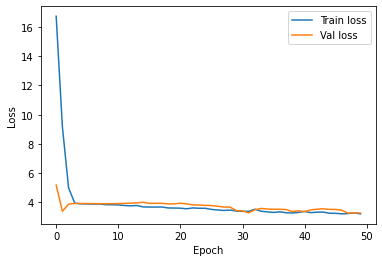

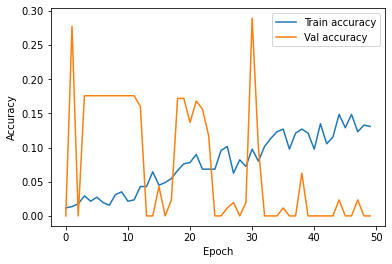

In [12]:

max_epochs = 50
train_steps = int(np.ceil(len(training_dataset)/128))
val_steps = int(np.ceil(len(validation_dataset)/128))

history = PiczakNet.fit(training_dataset,
                        epochs=max_epochs, 
                        validation_data=validation_dataset, 
                        validation_steps=val_steps,
                        steps_per_epoch=train_steps)
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


In [13]:
plt.figure()
plt.plot(epoch_loss, label='training loss')
plt.plot(epoch_vl, label='validation loss')
plt.legend()
plt.show()
plt.close('all')

NameError: name 'epoch_loss' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure()
plt.plot(epoch_acc, label='training acc')
plt.plot(epoch_va, label='validation acc')
plt.legend()
plt.show()
plt.close('all')

## Test on Other Folds

In [ ]:
#PiczakNet.evaluate(f3_processed, lf3_processed)

In [ ]:
#PiczakNet.evaluate(f4_processed, lf4_processed)

In [ ]:
#PiczakNet.evaluate(f5_processed, lf5_processed)